# Tests with Popoola's MLP for FL + IDS

## Authors given information

| Hyperparameter                    | Value                 |
| --------------------------------- | ---------------------:|
| Input neurons                     | 39                    |
| Hidden layers                     | 2                     |
| Neurons in each hidden layer      | 128                   |
| Hidden layer activation function  | ReLU                  |
| Output neuron                     | 1                     |
| Output layer activation function  | Sigmoid               |
| Optimisation algorithm            | Adam                  |
| Learning rate                     | 0.0001                |
| Batch size                        | 512                   |
| Epochs                            | 10                    |
| Loss function                     | Binary cross-entropy  |


In [1]:
import os
import psutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from time import time

keras = tf.keras


In [3]:
# Enable determinsim
SEED = 1138

tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()


In [4]:
from typing import Tuple
from dataset.data import Dataset
from dataset.nfv2 import load_data


cicids: Tuple[Dataset, Dataset] = load_data("data/sampled/cicids_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore

cicids_train, cicids_test = cicids



In [7]:
def build_model() -> keras.Model:

    model = keras.Sequential([
        keras.layers.Dense(128, activation='LeakyReLU', input_shape=[len(cicids_train.X.columns)]),
        keras.layers.Dense(128, activation='LeakyReLU'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


## CIC-IDS2017

In [8]:
cicids_model = build_model()
start = time()
load1, load5, load15 = psutil.getloadavg()
cpu_usage = (load5/os.cpu_count()) * 100
cicids_history = cicids_model.fit(
    cicids_train.to_sequence(batch_size=512, target=1),#, shuffle=True, seed=SEED),
    epochs=10,
    #batch_size=512,
)
training_time_cicids = time()-start 
cpu_usage_cicids = cpu_usage
loss, acc = cicids_model.evaluate(cicids_test.X, cicids_test.y)


Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1781 - accuracy: 0.9528
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0993 - accuracy: 0.9691
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0782 - accuracy: 0.9797
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0659 - accuracy: 0.9859
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0596 - accuracy: 0.9865
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0560 - accuracy: 0.9871
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0535 - accuracy: 0.9876
Epoch 8/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0515 - accuracy: 0.9884
Epoch 9/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0499 - accuracy: 0.9887
Epoch 10/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.047

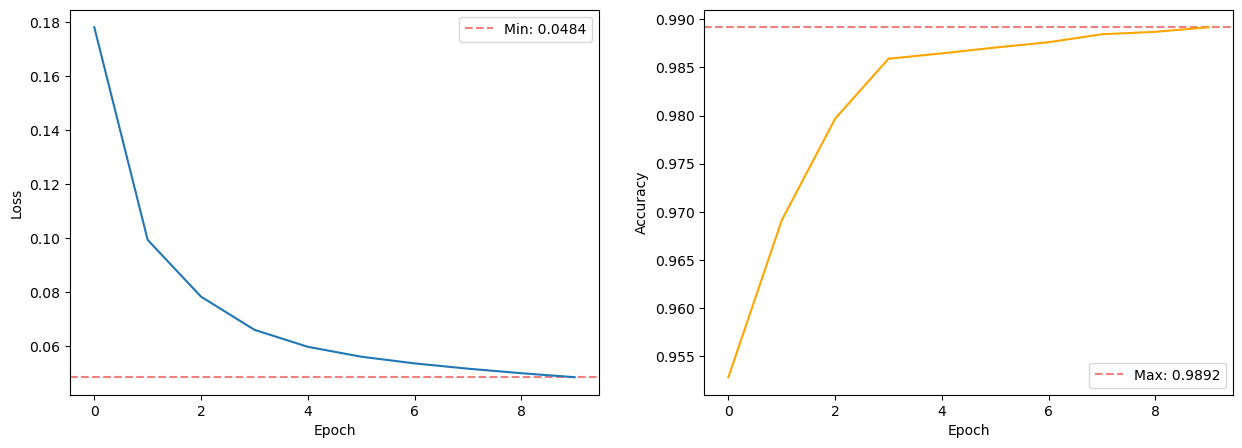

Accuracy: 0.9901


In [9]:


# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(cicids_history.history['loss'])
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(cicids_history.history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(cicids_history.history['accuracy'])
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(cicids_history.history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

print(f"Accuracy: {acc:.4f}")


In [10]:
# plot evaluation metrics
inferences = cicids_model.predict(cicids_test.X)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")

6250/6250 [==============================] - 7s 1ms/step
(200000, 1)
First 10 predictions:
[[8.0147414e-03]
 [9.5753986e-03]
 [7.9089412e-03]
 [9.3073852e-04]
 [8.7474594e-03]
 [1.1468668e-02]
 [7.7078672e-05]
 [2.8500944e-22]
 [9.8188994e-03]
 [9.7803613e-03]]


True Negatives: 175680
False Positives: 444
False Negatives: 1536
True Positives: 22340


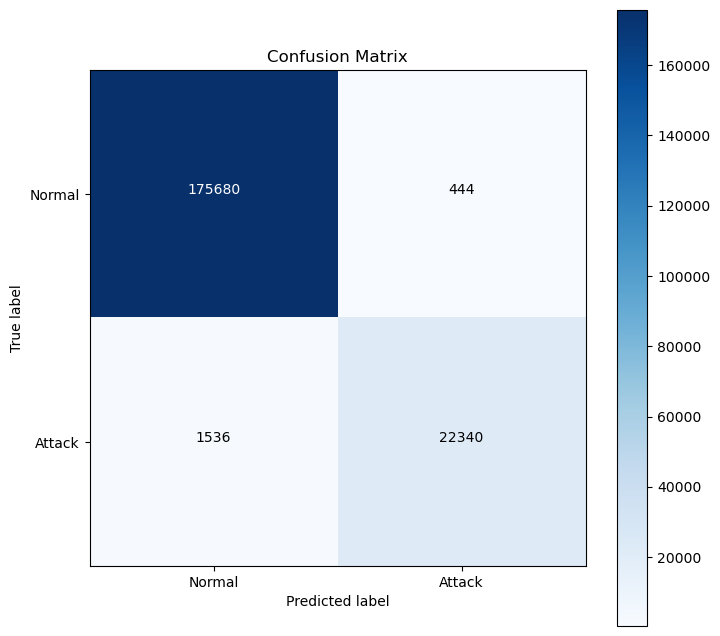

CIC-IDS Accuracy: 0.9901
CIC-IDS Precision: 0.9805
CIC-IDS Recall: 0.9357
CIC-IDS F1: 0.9576
CIC-IDS Miss Rate: 0.0643
CIC-IDS Loss: 0.0475
CIC-IDS Training Time: 44.5389
CIC-IDS CPU Usage: 0.0000


In [11]:
from sklearn.metrics import confusion_matrix

# convert to binary
#y_pred = np.argmax(np.round(inferences), axis=1)
y_pred = np.round(inferences).astype(int)#.reshape(1,-1)
#y_pred = inferences
#y_true = np.argmax(cicids_test.y.to_numpy(), axis=1)
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Loss: {loss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")




## Generalizing

In [12]:
from typing import Dict, List, Tuple
from numpy.typing import NDArray

botiot: Tuple[Dataset, Dataset] = load_data("data/sampled/botiot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore
nb15: Tuple[Dataset, Dataset] = load_data("data/sampled/nb15_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore
toniot: Tuple[Dataset, Dataset] = load_data("data/sampled/toniot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore



Weights = List[NDArray]

def eval_on(train, test) -> Tuple[Dict[str, float], Weights]:
    model = build_model()
    start = time()
    load1, load5, load15 = psutil.getloadavg()
    cpu_usage = (load5/os.cpu_count()) * 100
    model.fit(
        train.X,
        train.y,
        epochs=10,
        batch_size=512,
    )
    training_time_ = time()-start 
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model.get_weights()

In [13]:
cicids_results, cicids_weights = eval_on(*cicids)
nb15_results, nb15_weights = eval_on(*nb15)
toniot_results, toniot_weights = eval_on(*toniot)
botiot_results, botiot_weights = eval_on(*botiot)



Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1797 - accuracy: 0.9552
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0995 - accuracy: 0.9692
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0791 - accuracy: 0.9796
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0660 - accuracy: 0.9861
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0591 - accuracy: 0.9865
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0551 - accuracy: 0.9871
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0524 - accuracy: 0.9878
Epoch 8/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0504 - accuracy: 0.9886
Epoch 9/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0489 - accuracy: 0.9889
Epoch 10/10
6250/6250 [==============================] - 7s 1ms/step
Epoch 1/10
15

In [14]:

df_results: pd.DataFrame = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate","Training Time","CPU Usage"])

for dataset in [
    ("CIC-IDS", cicids_results), 
    ("UNSW-NB15", nb15_results),
    ("ToN-IoT", toniot_results),
    ("Bot-IoT", botiot_results),
]:
    df_results = df_results.append({
        "Dataset": dataset[0],
        "Accuracy": dataset[1]["acc"],
        "Precision": dataset[1]["prec"],
        "Recall": dataset[1]["rec"],
        "F1": dataset[1]["f1"],
        "Miss Rate": dataset[1]["miss"],
        "Training Time": dataset[1]["training time"],
        "CPU Usage": dataset[1]["cpu usage"]
    }, ignore_index=True)

df_results

C:\Users\AKSHAT\AppData\Local\Temp\ipykernel_46556\2685405361.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
C:\Users\AKSHAT\AppData\Local\Temp\ipykernel_46556\2685405361.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
C:\Users\AKSHAT\AppData\Local\Temp\ipykernel_46556\2685405361.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
C:\Users\AKSHAT\AppData\Local\Temp\ipykernel_46556\2685405361.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


Dataset  Accuracy  Precision    Recall        F1  Miss Rate  \
0    CIC-IDS  0.990115   0.980178  0.936128  0.957647   0.063872   
1  UNSW-NB15  0.995075   0.899532  0.986849  0.941169   0.013151   
2    ToN-IoT  0.948270   0.939856  0.982065  0.960497   0.017935   
3    Bot-IoT  0.998700   0.998932  0.999764  0.999348   0.000236   

   Training Time   CPU Usage  
0      37.563177   60.250000  
1      39.910399   86.250000  
2      39.718751   97.416667  
3      39.119402  111.250000

## Cross-dataset evaluation

In [15]:
# Compute cross f1 score between datasets (ie, model trained on one dataset and evaluated on another)

def cross_f1_score(weights: Weights, test: Dataset) -> float:
    model = build_model()
    model.set_weights(weights)
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int).reshape(-1)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    return f1

cross_comp_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for weights in [
    ("CIC-IDS", cicids_weights), 
    ("UNSW-NB15", nb15_weights),
    ("ToN-IoT", toniot_weights),
    ("Bot-IoT", botiot_weights),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_df.loc[cross_comp_df["Trained on"] == weights[0], f"{dataset[0]} F1"] = cross_f1_score(weights[1], dataset[1])

6250/6250 [==============================] - 7s 1ms/step


In [16]:
cross_comp_df

Trained on CIC-IDS F1 UNSW-NB15 F1 ToN-IoT F1 Bot-IoT F1
0    CIC-IDS   0.957647     0.003445   0.528306   0.543394
1  UNSW-NB15    0.10801     0.941169   0.010779   0.879591
2    ToN-IoT    0.23608      0.45298   0.960497   0.200402
3    Bot-IoT   0.158372     0.001509   0.698159   0.999348

## Testing for potential overfitting

In [ ]:
train, test = cicids

model = build_model()
hist = model.fit(
    train.X,
    train.y,
    epochs=100,
    batch_size=512,
)


In [ ]:
inferences = model.predict(test.X)
y_pred = np.round(inferences).astype(int)
y_true = test.y.to_numpy()
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = (tn + tp) / (tn + fp + fn + tp)
prec = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = 2 * prec * rec / (prec + rec)
miss = fn / (fn + tp)

In [ ]:
# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(hist.history['loss'])
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(hist.history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(hist.history['accuracy'])
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(hist.history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

# print evaluation metrics in a markdown table

print(f"""
| Metric | Value |
| ------ | ----- |
| Accuracy | {acc:.4f} |
| Precision | {prec:.4f} |
| Recall | {rec:.4f} |
| F1 | {f1:.4f} |
| Miss Rate | {miss:.4f} |
""")




In [ ]:
import numpy as np
print(np.array([1,2]))